<a href="https://colab.research.google.com/github/lakatosgabor/ogyei_dataset_info/blob/main/embedding_76.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -q -U jax jaxlib
!pip install -U "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

!pip install -q pandas
!pip install -q ipywidgets
!pip install -q -U flax
!pip install -q sentence-transformers
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q transformers
#!pip install -q torch torchvision

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import os
import sys
import json

import numpy as np
import pandas as pd

os.environ['TOKENIZERS_PARALLELISM'] = "false"

import transformers
from transformers import AutoTokenizer

import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode
from tqdm.notebook import tqdm

sys.path.append('.')

from modeling_hybrid_clip import FlaxHybridCLIP

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import jax
from jax import numpy as jnp
from transformers import FlaxVisionTextDualEncoderModel

TOKENIZER_NAME = "SZTAKI-HLT/hubert-base-cc"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, cache_dir=None, use_fast=True)
model = FlaxVisionTextDualEncoderModel.from_pretrained("/content/drive/MyDrive/model/76")
def tokenize(texts):
    inputs = tokenizer(texts, max_length=96, padding="max_length", return_tensors="np")
    return inputs['input_ids'], inputs['attention_mask']

language_model = lambda queries: np.asarray(model.get_text_features(*tokenize(queries)))
image_model = lambda images: np.asarray(model.get_image_features(images.permute(0, 2, 3, 1).numpy(),))

You are using a model of type hybrid-clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.


In [4]:
# Koszinus távolság számítása
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    distance = 1 - similarity
    return distance

In [12]:
# Szövegek, amelyeket be akarunk ágyazni
texts = ['acc long 600 mg pezsgőtabletta fehér színű, korong alakú, lapos felületű, metszett élű, szeder ízű és illatú pezsgőtabletta bemetszéssel az egyik oldalán. a bemetszés nem a tabletta széttörésére szolgál.', 'színtelen, tiszta folyadékot tartalmazó, átlátszó, ovális lágy kapszulák fekete „400” felirattal.', '10\xa0mg az atorvastatin-teva filmtabletta fehér, kerek, mindkét oldalán domború, egyik oldalán bemetszéssel, másik oldalán mélynyomású 10 jelöléssel ellátott filmtabletta. a tabletták átmérője hozzávetőleg 7\xa0mm.', '10\xa0mg az atorvastatin-teva filmtabletta fehér, kerek, mindkét oldalán domború, egyik oldalán bemetszéssel, másik oldalán mélynyomású 10 jelöléssel ellátott filmtabletta. a tabletták átmérője hozzávetőleg 7\xa0mm.',]


In [39]:
text_embeddings = language_model(texts)

In [41]:
# Koszinus távolságok számítása és normalizálása
text_distances = []
text_pairs = []

for i, vec1 in enumerate(text_embeddings):
    for j, vec2 in enumerate(text_embeddings):
        distance = cosine_distance(vec1, vec2)
        text_distances.append(distance)
        text_pairs.append((texts[i], texts[j]))


# Normalizálás
text_normalized_distances = (text_distances - np.min(text_distances)) / (np.max(text_distances) - np.min(text_distances))

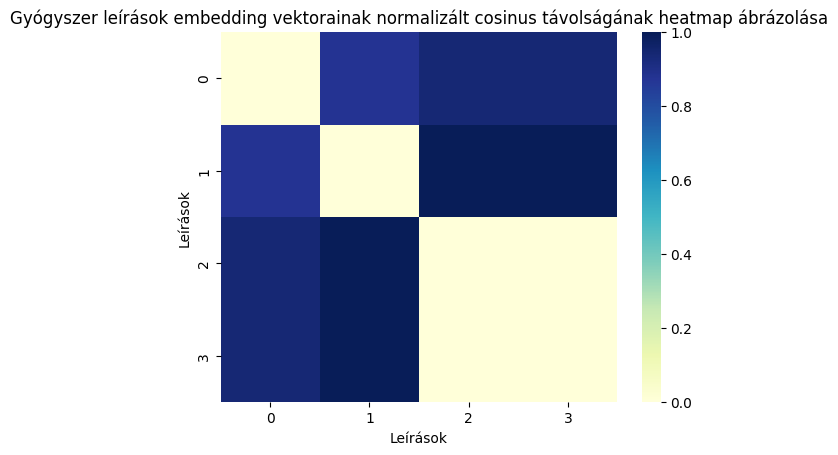

In [42]:
data = text_normalized_distances.reshape(4,4)

# Heatmap létrehozása seaborn segítségével
sns.heatmap(data, annot=False, cmap='YlGnBu', fmt='.2f')

# Tengelycímkék beállítása
plt.xlabel('Leírások')
plt.ylabel('Leírások')
plt.title('Gyógyszer leírások embedding vektorainak normalizált cosinus távolságának heatmap ábrázolása')

# Diagram megjelenítése
plt.show()

In [57]:
image_paths = ['/content/huto.jpg', '/content/kutya.jpg', '/content/kutyajatszik.jpg', '/content/macska.jpg']

In [ ]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
	def __init__(self):
		self.imgs_path = "/content/images/"
		file_list = glob.glob(self.imgs_path + "*")
		print(file_list)
		self.data = []
		for class_path in file_list:
			class_name = class_path.split("/")[-1]
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
		print(self.data)
		self.class_map = {"1" : 1, "2": 2, "3": 3, "4": 4}
		self.img_dim = (224, 224)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = cv2.imread(img_path)
		img = cv2.resize(img, self.img_dim)
		class_id = self.class_map[class_name]
		img_tensor = torch.from_numpy(img)
		img_tensor = img_tensor.permute(2, 0, 1)
		class_id = torch.tensor([class_id])
		return img_tensor, class_id

dataset = CustomDataset()
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)
for imgs, labels in data_loader:
  print("Batch of images has shape: ",imgs.shape)
  print("Batch of labels has shape: ", labels.shape)

In [74]:
for i, (images, target) in enumerate(tqdm(data_loader)):
  images = images
  image_features = image_model(images)
  image_features = image_features / np.linalg.norm(image_features, axis=-1, keepdims=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
# Koszinus távolságok számítása és normalizálása
image_distances = []
image_pairs = []
for i, img_vec1 in enumerate(image_features):
    for j, img_vec2 in enumerate(image_features):
        distance = cosine_distance(img_vec1, img_vec2)
        image_distances.append(distance)
        image_pairs.append((image_paths[i], image_paths[j]))

# Normalizálás
image_normalized_distances = (image_distances - np.min(image_distances)) / (np.max(image_distances) - np.min(image_distances))

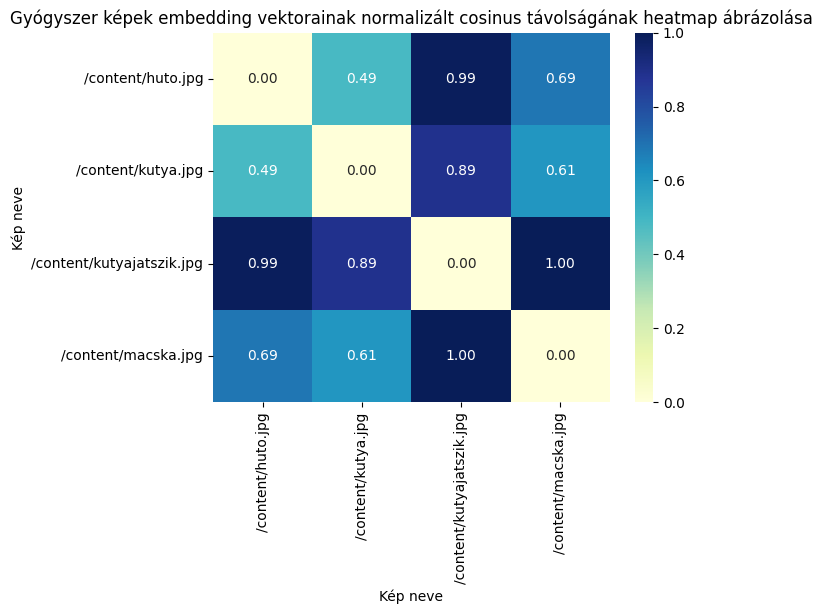

In [77]:
data = image_normalized_distances.reshape(4,4)

# Heatmap létrehozása seaborn segítségével
sns.heatmap(data, annot=True, cmap='YlGnBu', fmt='.2f', xticklabels=image_paths, yticklabels=image_paths)

# Tengelycímkék beállítása
plt.xlabel('Kép neve')
plt.ylabel('Kép neve')
plt.title('Gyógyszer képek embedding vektorainak normalizált cosinus távolságának heatmap ábrázolása')

# Diagram megjelenítése
plt.show()

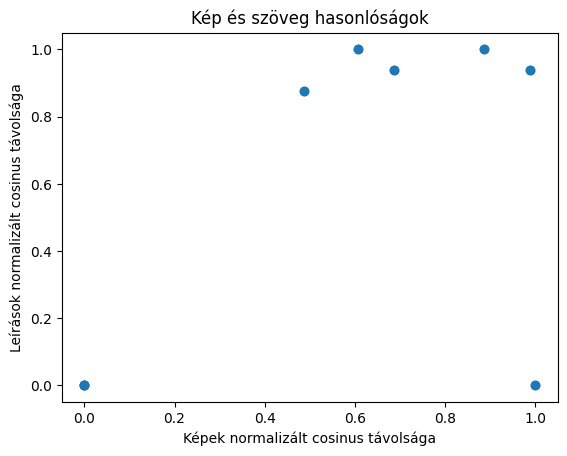

In [78]:
# Pontok ábrázolása
plt.scatter(image_normalized_distances, text_normalized_distances)

# Az x és y tengelyek címkézése
plt.xlabel('Képek normalizált cosinus távolsága')
plt.ylabel('Leírások normalizált cosinus távolsága')
plt.title('Kép és szöveg hasonlóságok')

# Diagram megjelenítése
plt.show()